## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
data.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
title        object
dtype: object

In [11]:
vars_num = [var for var in data.columns if data[var].dtype !="object"]

vars_cat = [var for var in data.columns if data[var].dtype =="object"]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [12]:
# first in numerical variables

num_vars_w_na = [var for var in data[vars_num].columns if data[var].isnull().sum() > 0]
num_vars_w_na

['age', 'fare']

In [13]:
# now in categorical variables

cat_vars_w_na = [var for var in data[vars_cat].columns if data[var].isnull().sum() > 0]
cat_vars_w_na

['cabin', 'embarked']

### Determine cardinality of categorical variables

In [14]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

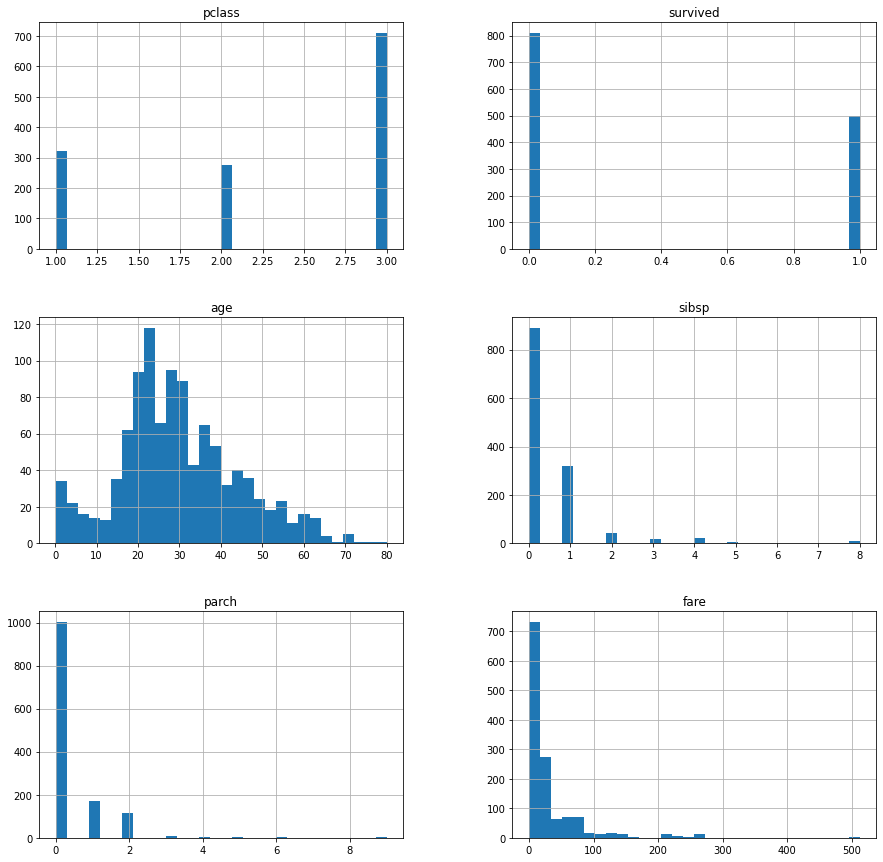

In [15]:
data[vars_num].hist(bins=30, figsize=(15,15))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [17]:
X_train["cabin"] = X_train["cabin"].str[0]
X_test["cabin"] = X_test["cabin"].str[0]

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [18]:
# replace missing values as we described above

for var in num_vars_w_na:

    # calculate the mean using the train set
    mean_val = X_train[var].mean()
    
    print(var, mean_val)

    # add binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

# check that we have no more missing values in the engineered variables
X_train[num_vars_w_na].isnull().sum()
#[var for var in num_vars_w_na if X_test[var].isnull().sum() > 0]

age 30.05182318668252
fare 33.744757456978974


age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [19]:
X_train[cat_vars_w_na ].isnull().mean().sort_values(ascending=False)

cabin       0.766953
embarked    0.001910
dtype: float64

In [20]:
X_train[cat_vars_w_na] = X_train[cat_vars_w_na].fillna('Missing')
X_test[cat_vars_w_na] = X_test[cat_vars_w_na].fillna('Missing')

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [21]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index

In [22]:
for var in vars_cat:
    freq_ls = find_frequent_labels(X_train, var, 0.05)
    
    X_train[var] = np.where(X_train[var].isin(freq_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(freq_ls), X_test[var], 'Rare')

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [23]:
def one_hot_encode(df, columns):
    dummy_df = pd.get_dummies(df[columns], drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)
    df.drop(columns=columns, inplace=True)
    return df

In [24]:
X_train = one_hot_encode(X_train, vars_cat)
X_test = one_hot_encode(X_test, vars_cat)

In [25]:
X_test["embarked_Rare"]=0

In [26]:
prediction_vars = X_train.columns

### Scale the variables

- Use the standard scaler from Scikit-learn

In [27]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[prediction_vars]) 

# transform the train and test set

X_train = scaler.transform(X_train[prediction_vars])

X_test = scaler.transform(X_test[prediction_vars])


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [28]:
lr = LogisticRegression(C=0.0005, random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [29]:
pred = lr.predict(X_train)
prob = lr.predict_proba(X_train)[:,1]

# determine mse, rmse and r2
print('train accuracy: {}'.format(
    accuracy_score(y_train, pred)))
print('train auc: {}'.format(
    roc_auc_score(y_train, prob)))
print()

# make predictions for test set
pred = lr.predict(X_test)
prob = lr.predict_proba(X_test)[:,1]

# determine mse, rmse and r2
# determine mse, rmse and r2
print('train accuracy: {}'.format(
    accuracy_score(y_test, pred)))
print('train auc: {}'.format(
    roc_auc_score(y_test, prob)))
print()

train accuracy: 0.7134670487106017
train auc: 0.843856259659969

train accuracy: 0.6984732824427481
train auc: 0.8347222222222221



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**